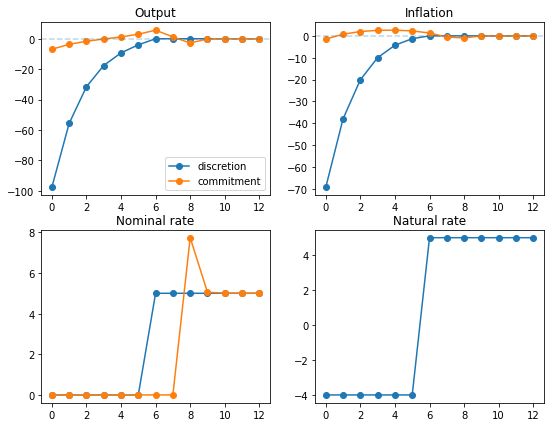

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import warnings
warnings.filterwarnings('ignore')


rho = 5  # 自然利率
alpha = 0.5 # 资本份额
beta = 0.99  # 跨期贴现率
sigma = 1  # 消费的跨期替代弹性的倒数
theta = 3/5  # 名义粘性指数（一个季度内价格不变的企业比例）
phi = 5  # 劳动的跨期替代弹性的倒数（其倒数是Fisher劳动供给弹性）
e = 9  # 产品的替代弹性
lam = (1-theta)/theta*(1-beta*theta)*(1-alpha)/(1-alpha+alpha*e);  
psi_ya = (1+phi)/(sigma*(1-alpha)+phi+alpha)
k = (sigma+(phi+alpha)/(1-alpha))*lam  # NKPC 参数 ：pi_t = E pi_{t+1} + k x_t + u_t
Theta = k/e  # 福利损失函数中产出缺口相对于通胀率的比重
gamma = Theta/(k**2+Theta*(1+beta))  # \hat{p}_t = \gamma*\hat{p}_{t-1}+\gamma\beta\hat{p}_{t+1} +\kappa\Lambda/Theta \delta/(1-\beta\delta\rho_u)u_t
delta = (1-np.sqrt(1-4*gamma**2*beta))/(2*gamma*beta)  # 由上式迭代得出的价格的一阶自回归系数
Lambda = lam/e**2  # 平衡路径不同于有效路径的前提下，福利损失函数中产出波动的一阶项系数

T = 12  # 总期数
tz = 5  # 在前tz期，自然利率为负，然后回到正常水平rho
xpi = np.zeros((2,T+1))  # 第0期到第12期
er = 4  # 负实际利率

# 一下两个矩阵刻画了产出缺口（这里指同有效产出的缺口，而非同自然产出的缺口）与通胀的动态
A = Matrix([[1,1/sigma],[k,beta+k/sigma]])  
B = Matrix([[1/sigma],[k/sigma]])

# 名义和实际利率
r = np.append(np.ones(tz+1)*-er,np.ones(T-tz)*rho)
it = np.append(np.zeros(tz+1),np.ones(T-tz)*rho)

# Case1 : 自由裁量（相机决策）
# 央行每一期单独优化，而不是考虑全时期总体优化，在冲击结束后，产出缺口和通胀都立即回到0
# 由于每一期的决策只取决于当期的影响，因此称“相机决策”
for i in range(tz+1):
    xpi[:,tz-i:tz+1-i] = A@xpi[:,tz+1-i:tz+2-i]-er*B
    
    
# Case2 : 可信承诺（前瞻指引）   
# 央行最小化损失函数贴现和，尽管有更多时期产出缺口为负，但是显著减小冲击在初期造成的影响，由于效用函数的凹性，总的福利损失比相机决策少。
tc = 7  # 在7期以后才让利率回升
xpi_c = np.zeros((2,T+1))
M = np.linalg.inv(np.array([[-k,1+beta*(1-delta)],[beta*(1-delta)+k**2/Theta,-k/Theta]]))@np.array([[beta*(1-delta),(1-delta)/sigma],[0,(1-delta)/Theta]])
H = Matrix([[1,1/beta/sigma],[k,1/beta*(1+k/sigma)]])
J = np.array([[0,1],[Theta,k]])

# 第tc+1期是一个转折点，这一期的状态变量待定
x = Symbol('x')
y = Symbol('y')

# 利用动态方程（以及初值）迭代求解tc+1期的状态变量
xpi_c = Matrix(xpi_c)
xpi_c[:,tc+1:tc+2] = np.array([[x],[y]]) 
for i in range(tc-tz):
    xpi_c[:,tc-i:tc+1-i] = A@xpi_c[:,tc+1-i:tc+2-i]+rho*B
for i in range(tz+1):
    xpi_c[:,tz-i:tz+1-i] = A@xpi_c[:,tz+1-i:tz+2-i]-er*B
summ = Matrix(np.zeros_like(xpi_c[:,tc+1:tc+2]))
for j in range(tc+1):
    summ += H**j@J@Matrix(xpi_c[:,tc-j:tc+1-j])
sol = solve(M@summ+xpi_c[:,tc+1:tc+2],[x,y])
xpi_c[:,tc+1:tc+2] = np.array([[sol[x]],[sol[y]]])

# 再求出各期状态变量
for i in range(tc-tz):
    xpi_c[:,tc-i:tc+1-i] = A@xpi_c[:,tc+1-i:tc+2-i]+rho*B
for i in range(tz+1):
    xpi_c[:,tz-i:tz+1-i] = A@xpi_c[:,tz+1-i:tz+2-i]-er*B

# 求出各期拉格朗日参数 并根据tc+1期的参数计算之后各时期的状态变量
xis = Matrix(np.zeros((2,T+2))) # 从-1开始
for i in range(tc+2):
    xis[:,i+1:i+2] = H@xis[:,i:i+1]-J@xpi_c[:,i:i+1]
for i in range(T-tc-1):
    xpi_c[0,tc+2+i] = k*delta**(i+1)/Theta*xis[0,tc+2]
    xpi_c[1,tc+2+i] = (1-delta)*delta**i*xis[0,tc+2]
xpi_c = np.asarray(xpi_c)

# 计算名义利率
it_c = r.copy()
for i in range(len(r)-1):
    it_c[i] += xpi_c[1,i+1]+sigma*(xpi_c[0,i+1]-xpi_c[0,i]) 

# 画图
fig,axes = plt.subplots(2,2,figsize=(9,7))
axes[0,0].plot(xpi[0],'-o',label='discretion')
axes[0,0].plot(xpi_c[0],'-o',label='commitment')
axes[0,0].axhline(0,alpha=0.3,ls='--')
axes[0,0].legend()
axes[0,0].set_title('Output')

axes[0,1].plot(xpi[1],'-o',label='discretion')
axes[0,1].plot(xpi_c[1],'-o',label = 'commitment')
axes[0,1].axhline(0,alpha=0.3,ls='--')
axes[0,1].set_title('Inflation')

axes[1,0].plot(it,'-o',label = 'discretion')
axes[1,0].plot(it_c,'-o',label='commitment')
axes[1,0].set_title('Nominal rate')

axes[1,1].plot(r,'-o')
axes[1,1].set_title('Natural rate')

for ax in axes.flatten():
    ax.set_xticks(np.linspace(0,T,T/2+1))

In [50]:
print(gamma,delta,lam,Lambda,k,Theta,psi_ya)

0.203533338760889 0.21264462224542016 0.027066666666666673 0.0003341563786008231 0.3248000000000001 0.0360888888888889 1.0


In [26]:
theta**4

0.31640625